In [10]:
# !pip install opencv-python
# !pip install scikit-image
# !pip install dlib

In [1]:
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import dlib

In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir)
os.getcwd()

'/Users/pareshar/Personal/Github/Facial-feature-detector'

In [3]:
# static variables
path_to_images = "data/images_symmetry//"
image_files = os.listdir(path_to_images)

# Helper functions

In [4]:
def histogram_performance(left_half, right_half):
    hist_left = cv2.calcHist([left_half], [0], None, [256], [0, 256])
    hist_right = cv2.calcHist([right_half], [0], None, [256], [0, 256])

    # Normalize histograms
    hist_left /= hist_left.sum()
    hist_right /= hist_right.sum()

    # Compare using various methods
    correlation = cv2.compareHist(hist_left, hist_right, cv2.HISTCMP_CORREL)
    chi_square = cv2.compareHist(hist_left, hist_right, cv2.HISTCMP_CHISQR)
    intersection = cv2.compareHist(hist_left, hist_right, cv2.HISTCMP_INTERSECT)
    bhattacharyya = cv2.compareHist(hist_left, hist_right, cv2.HISTCMP_BHATTACHARYYA)

    return correlation, chi_square, intersection, bhattacharyya

def orb_detector(left_half, right_half):
    """The fewer the matches (or the greater the average distance), the more dissimilar the images"""

    orb = cv2.ORB_create()
    keypoints_left, descriptors_left = orb.detectAndCompute(left_half, None)
    keypoints_right, descriptors_right = orb.detectAndCompute(right_half, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors_left, descriptors_right)
    matches = sorted(matches, key=lambda x: x.distance)
    return len(matches)

def align_face(face_image, predictor_path="models/face_alignment/shape_predictor_68_face_landmarks.dat"):
    # If the image is not grayscale, convert it.
    if len(face_image.shape) == 3 and face_image.shape[2] == 3:
        gray = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
    else:
        gray = face_image.copy()

    # Initialize dlib's face detector and shape predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    
    # Detect the face in the image
    faces = detector(gray, 1)
    if len(faces) == 0:
        print("No face detected.")
        return face_image

    face = faces[0]
    
    # Get the landmarks/parts for the face
    shape = predictor(gray, face)
    
    # Get the center between the two eyes for the face
    left_eye_center = (0.5 * (shape.part(36).x + shape.part(39).x), 0.5 * (shape.part(36).y + shape.part(39).y))
    right_eye_center = (0.5 * (shape.part(42).x + shape.part(45).x), 0.5 * (shape.part(42).y + shape.part(45).y))
    
    # Compute the angle between the two eyes
    dy = right_eye_center[1] - left_eye_center[1]
    dx = right_eye_center[0] - left_eye_center[0]
    angle = np.degrees(np.arctan2(dy, dx))
    
    # Compute the desired right eye x-coordinate based on the left eye x-coordinate
    desired_right_eye_x = 1.0 - 0.3
    
    # Determine the scale of the new resulting image
    dist = np.sqrt((dx ** 2) + (dy ** 2))
    desired_dist = (desired_right_eye_x - 0.3)
    desired_dist *= 224  # the width of image we want to use
    scale = desired_dist / dist
    
    # Compute center (x, y) between the two eyes in the input image
    eyes_center = ((left_eye_center[0] + right_eye_center[0]) // 2, (left_eye_center[1] + right_eye_center[1]) // 2)
    
    # Grab the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)
    
    # Update the translation component of the matrix at the last column
    tX = 224 * 0.5
    tY = 224 * 0.4
    M[0, 2] += (tX - eyes_center[0])
    M[1, 2] += (tY - eyes_center[1])
    
    # Use the affine transformation to produce the aligned face
    aligned = cv2.warpAffine(gray, M, (224, 224), flags=cv2.INTER_CUBIC)
    
    return aligned

# Model 1: CascadeClassifier

- Weakness - can't detect side of face

In [5]:
df = pd.DataFrame(columns=["file_name", "model", "structural_similarity", "cosine_distance", "mse", "mae",
                           "histogram_correlation", "histogram_intersection",
                           "orb_detector_matches", "pixel_difference"])
df_list = []

for image_file in image_files:
    image = cv2.imread(path_to_images + image_file)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=10, minSize=(30, 30))
    # print(f"Number of faces found: {faces.shape[0]}")
    
    x, y, w, h = faces[0]
    startX, startY, endX, endY = x, y, x+w, y+h
    face = image[startY:endY, startX:endX]
    
    face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    face = cv2.equalizeHist(face) # remove illumination
    face = cv2.GaussianBlur(face, (5, 5), 0) # remove noise
    # face = align_face(face) # time consuming and worsens result - remove
    
    mid = face.shape[1] // 2
    left_half = face[:, :mid]
    right_half = face[:, mid:]
    
    right_half = cv2.resize(right_half, (left_half.shape[1], left_half.shape[0]))
    right_half = cv2.flip(right_half, 1)  

    structural_similarity, _ = ssim(left_half, right_half, full=True)
    cosine_distance = distance.cosine(left_half.ravel(), right_half.ravel())
    mse = mean_squared_error(left_half, right_half)
    mae = mean_absolute_error(left_half, right_half)
    correlation, chi_square, intersection, bhattacharyya = histogram_performance(left_half, right_half)
    matches = orb_detector(left_half, right_half)
    pixel_difference = np.sum((left_half - right_half)**2)

    df_list.append({
        "file_name": image_file,
        "model": "CascadeClassifier",
        "structural_similarity": structural_similarity,
        "cosine_distance": cosine_distance,
        "mse": mse,
        "mae": mae,
        "histogram_correlation": correlation,
        "histogram_intersection": intersection,
        "orb_detector_matches": matches,
        "pixel_difference": pixel_difference
    })

df = pd.concat([df, pd.DataFrame(df_list)], ignore_index=True).round(2).sort_values("mse")

In [6]:
df

,file_name,model,structural_similarity,cosine_distance,mse,mae,histogram_correlation,histogram_intersection,orb_detector_matches,pixel_difference
3,symmetric_face.png,CascadeClassifier,0.89,0.13,37.09,144.65,0.95,0.95,77,918103
1,rihanna.webp,CascadeClassifier,0.78,0.15,41.03,150.27,0.92,0.97,270,5473063
2,gigi_hadid.webp,CascadeClassifier,0.63,0.18,78.60,106.03,0.86,0.90,189,45882205
5,beyonce.jpg,CascadeClassifier,0.45,0.16,80.90,122.51,0.93,0.98,416,70056971
11,leonardo_dicaprio.jpeg,CascadeClassifier,0.54,0.16,83.40,87.93,0.06,0.91,149,22742813
12,jay_z.jpg,CascadeClassifier,0.37,0.15,90.02,132.36,0.01,0.91,153,78483043
14,mike_tyson.jpg,CascadeClassifier,0.25,0.16,99.78,153.01,0.20,0.82,138,16123620
13,older_ronaldhino.jpg,CascadeClassifier,0.32,0.13,100.63,132.14,0.04,0.74,0,306127
8,me_45_degrees.jpg,CascadeClassifier,0.56,0.16,100.87,128.42,-0.85,0.77,46,110171745
6,limited_jawline_2.jpg,CascadeClassifier,0.18,0.16,101.82,158.23,0.36,0.75,0,211776


# Model 2: Single Shot MultiBox Detector (SSD) framework with a ResNet base network

The detections output from the net.forward() method (when using the Single Shot MultiBox Detector (SSD) with a ResNet base network for face detection) is a 4-dimensional array:

Batch Size: Number of images in the blob. In your code, you're working with a single image, so detections.shape[0] would be 1.

Number of Detected Boxes: This value (typically detections.shape[2]) represents the number of potential detections returned by the SSD. Note that not all of these detections are necessarily valid faces. Each detection is associated with a confidence score, and only detections with a confidence score above a certain threshold (e.g., 0.5) are usually considered as valid face detections.

Information per Detection: Each detection contains a vector of information. For the given model, this is typically of length 7, described as follows:

detections[0, 0, i, 0]: Image ID. As you're working with a single image, this will always be 0.
detections[0, 0, i, 1]: Class ID. Since the model is trained for face detection, this should represent the ID associated with "face". Depending on the pre-trained model, this is often 1.
detections[0, 0, i, 2]: Confidence score. It indicates the probability that the detected region is a face.
detections[0, 0, i, 3]: Starting X-coordinate of the bounding box.
detections[0, 0, i, 4]: Starting Y-coordinate of the bounding box.
detections[0, 0, i, 5]: Ending X-coordinate of the bounding box.
detections[0, 0, i, 6]: Ending Y-coordinate of the bounding box.

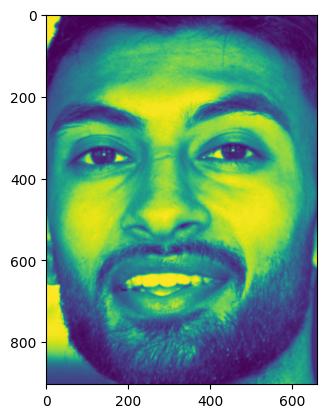

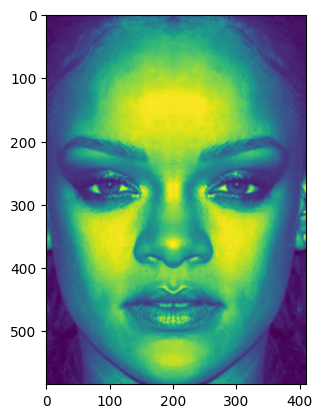

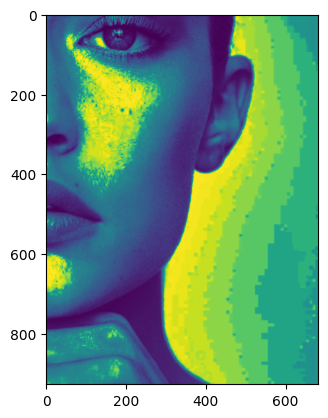

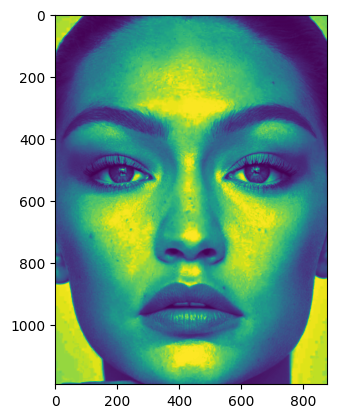

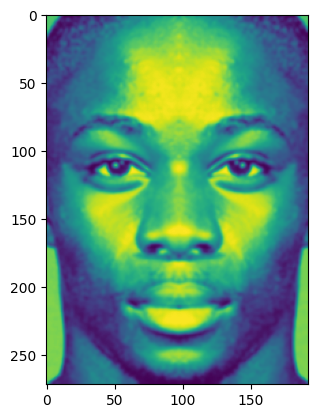

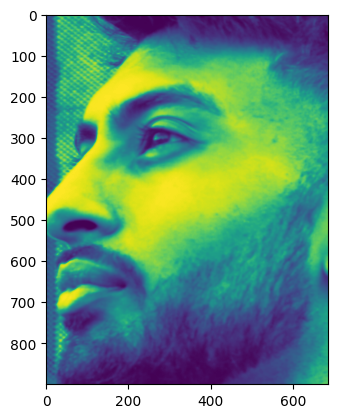

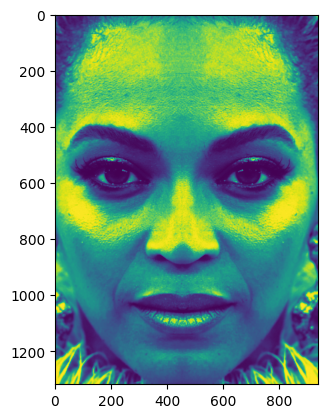

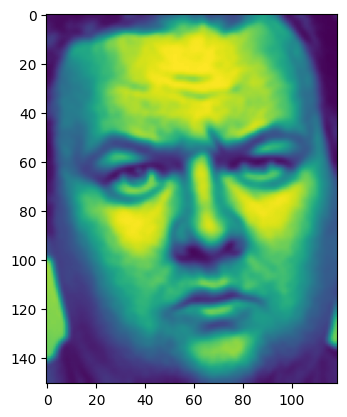

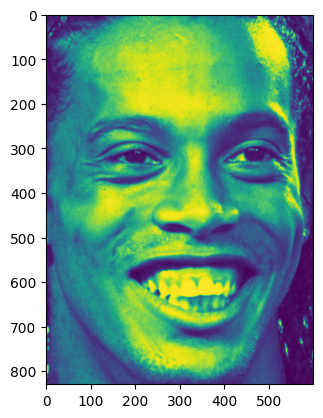

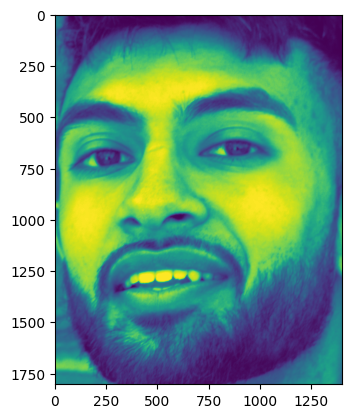

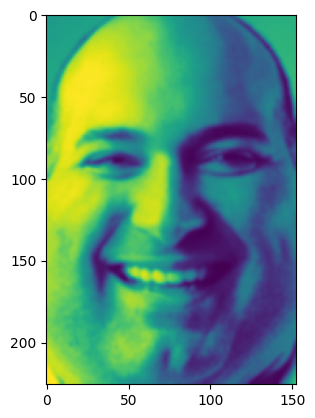

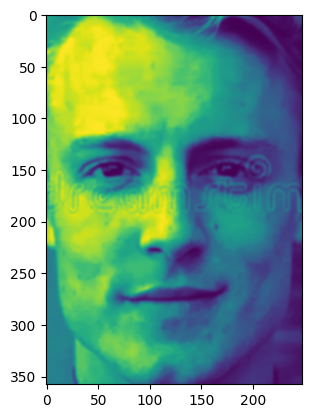

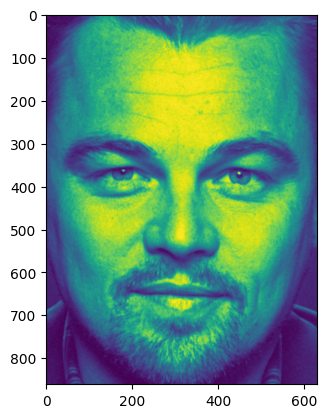

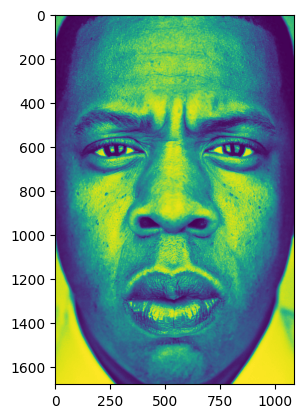

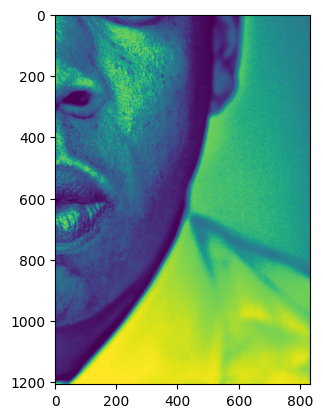

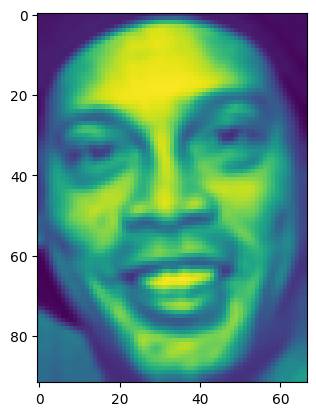

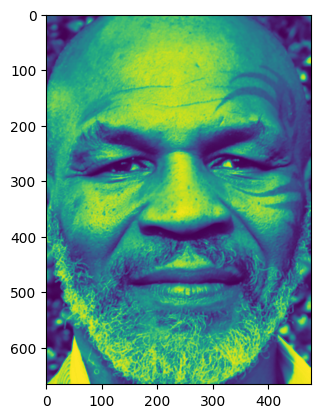

In [7]:
df = pd.DataFrame(columns=["file_name", "model", "structural_similarity", "cosine_distance", "mse", "mae",
                           "histogram_correlation", "histogram_intersection",
                           "orb_detector_matches", "pixel_difference"])
df_list = []

for image_file in image_files:
    image = cv2.imread(path_to_images + image_file)
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image=image, scalefactor=1.0, size=(300, 300))
    
    net = cv2.dnn.readNetFromCaffe("models/face_detection/deploy.prototxt.txt", "models/face_detection/res10_300x300_ssd_iter_140000.caffemodel")
    net.setInput(blob)
    detections = net.forward()  
    
    best_face_data = None
    lowest_mse = float('inf')
    
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.99:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            face = image[startY:endY, startX:endX]
            
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            face = cv2.equalizeHist(face) # remove illumination
            face = cv2.GaussianBlur(face, (5, 5), 0) # remove noise
            # face = align_face(face) # optional - make things slower and small effect
            
            mid = face.shape[1] // 2
            left_half = face[:, :mid]
            right_half = face[:, mid:]
            
            right_half = cv2.resize(right_half, (left_half.shape[1], left_half.shape[0]))
            right_half = cv2.flip(right_half, 1)    
            
            plt.imshow(face)
            plt.show()    

            structural_similarity, _ = ssim(left_half, right_half, full=True)
            cosine_distance = distance.cosine(left_half.ravel(), right_half.ravel())
            mse = mean_squared_error(left_half, right_half)
            mae = mean_absolute_error(left_half, right_half)
            correlation, chi_square, intersection, bhattacharyya = histogram_performance(left_half, right_half)
            matches = orb_detector(left_half, right_half)
            pixel_difference = np.sum((left_half - right_half)**2)

            d = {
            "file_name": image_file,
            "model": "ResNetSSD",
            "structural_similarity": structural_similarity,
            "cosine_distance": cosine_distance,
            "mse": mse,
            "mae": mae,
            "histogram_correlation": correlation,
            "histogram_intersection": intersection,
            "orb_detector_matches": matches,
            "pixel_difference": pixel_difference,
        }

        # Update the best_face_data if the current face has a lower MSE
        if d["mse"] < lowest_mse:
            best_face_data = d
            lowest_mse = d["mse"]

    if best_face_data:
        # Once all faces in the image have been processed, append the best face data to df_list
        df_list.append(best_face_data)

df = pd.concat([df, pd.DataFrame(df_list)], ignore_index=True).round(2).sort_values("mse")  

In [17]:
df.sort_values("mse") 

,file_name,model,structural_similarity,cosine_distance,mse,mae,histogram_correlation,histogram_intersection,orb_detector_matches,pixel_difference
3,symmetric_face.png,ResNetSSD,0.72,0.14,73.00,85.30,0.86,0.94,42,1906181
1,rihanna.webp,ResNetSSD,0.71,0.15,74.82,174.11,0.62,0.95,239,8957959
2,gigi_hadid.webp,ResNetSSD,0.62,0.13,78.51,137.55,0.59,0.91,186,41081965
9,jay_z.jpg,ResNetSSD,0.43,0.14,83.55,146.76,-0.04,0.93,160,76036226
8,leonardo_dicaprio.jpeg,ResNetSSD,0.52,0.15,83.62,97.05,0.46,0.94,162,22677675
5,beyonce.jpg,ResNetSSD,0.41,0.16,90.01,124.73,0.87,0.97,370,55637415
0,me.jpg,ResNetSSD,0.44,0.17,99.17,122.00,-0.63,0.88,138,29642693
11,mike_tyson.jpg,ResNetSSD,0.26,0.17,99.43,153.28,0.35,0.81,136,15759937
4,me_sideways.jpg,ResNetSSD,0.47,0.16,100.38,141.11,-0.83,0.82,29,30988712
10,older_ronaldhino.jpg,ResNetSSD,0.33,0.15,102.60,145.88,0.05,0.76,0,311494


# Assessing performance

---

- If you need to find even the slightest differences between images, a pixel-by-pixel approach might be suitable.

- If you want to compare the perceived visual similarity between images, SSIM or deep learning-based methods can be more appropriate.

- If you're determining if two images show the same object or scene, feature-based or deep learning comparisons can be useful.

---

# Model options

---

## Popular Face Detection Models in Python

### 1. **OpenCV's Haar Cascades**
- **Pros**: 
  - Fast and lightweight.
  - Works offline.
  - Included with OpenCV; easy integration if you're using OpenCV.
- **Cons**: 
  - Less accurate than deep learning-based methods.
  - Struggles in complex lighting or with non-frontal faces.

### 2. **Dlib's HOG-based face detector**
- **Pros**: 
  - More accurate than Haar Cascades.
  - Works offline and is reasonably fast.
- **Cons**: 
  - Might miss non-frontal or partially occluded faces.

### 3. **Dlib's CNN-based face detector**
- **Pros**: 
  - Highly accurate, even with non-frontal faces.
- **Cons**: 
  - Slower than HOG-based detector.
  - Requires more computational resources.

### 4. **MTCNN (Multi-task Cascaded Convolutional Networks)**
- **Pros**: 
  - High accuracy.
  - Detects faces at various scales.
- **Cons**: 
  - Slower, especially on CPUs.

### 5. **Single Shot MultiBox Detector (SSD) with ResNet or MobileNet backbone**
- **Pros**: 
  - Efficient and accurate.
  - Real-time detection capability on decent GPUs.
- **Cons**: 
  - Demands more computational resources.

### 6. **FaceBoxes**
- **Pros**: 
  - Balances speed and accuracy.
- **Cons**: 
  - Not as widely adopted.

### 7. **Ultra-Lightweight Face Detection Model**
- **Pros**: 
  - Designed for edge devices.
  - Good performance on limited-resource devices.
- **Cons**: 
  - Might trade accuracy for speed.

### 8. **BlazeFace (by Google)**
- **Pros**: 
  - Fast and lightweight.
  - Ideal for mobile and web applications.
- **Cons**: 
  - Might not be as accurate as some heavier models.

### 9. **MediaPipe by Google**
- **Pros**: 
  - Offers end-to-end pipelines for various vision tasks.
  - Optimized for mobile devices.
- **Cons**: 
  - More of a full toolkit than a standalone model.

### 10. **DeepFace (and similar libraries)**
- **Note**: 
  - Often wraps multiple face recognition models.
  - Typically come with face detection capabilities.

---

## Out of scope
- Hair falling in different places? Facial accessories?
- Test with two faces
- How to do the same but for bodies
- Can you factor in for the person requesting e.g. if you're a man you might prefer a woman, if you're a man at 30 you might find a woman at 50 unattractive but a man at 50 may find her more attractive?